# Data Sources

Common data sources for predictive maintenance problems are :

* **Failure history:** The failure history of a machine or component within the machine.
* **Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
* **Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.
* **Machine features:** The features of a machine, e.g. engine size, make and model, location.
* **Operator features:** The features of the operator, e.g. gender, past experience
The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [2]:
import pandas as pd

telemetry = pd.read_csv('data/PdM_telemetry.csv')
#errors = pd.read_csv('PdM_errors.csv')
#maint = pd.read_csv('PdM_maint.csv')
#failures = pd.read_csv('PdM_failures.csv')
#machines = pd.read_csv('PdM_machines.csv')

In [3]:
# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

print("Total number of telemetry records: %d" % len(telemetry.index))
print(telemetry.head())
telemetry.describe()

Total number of telemetry records: 876100
             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  


,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


#### **Telemetry**
The first data source is the telemetry time-series data which consists of **voltage, rotation, pressure, and vibration** measurements collected from 100 machines in **real time averaged over every hour collected during the year 2015**. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

Text(0.5, 0, 'Date')

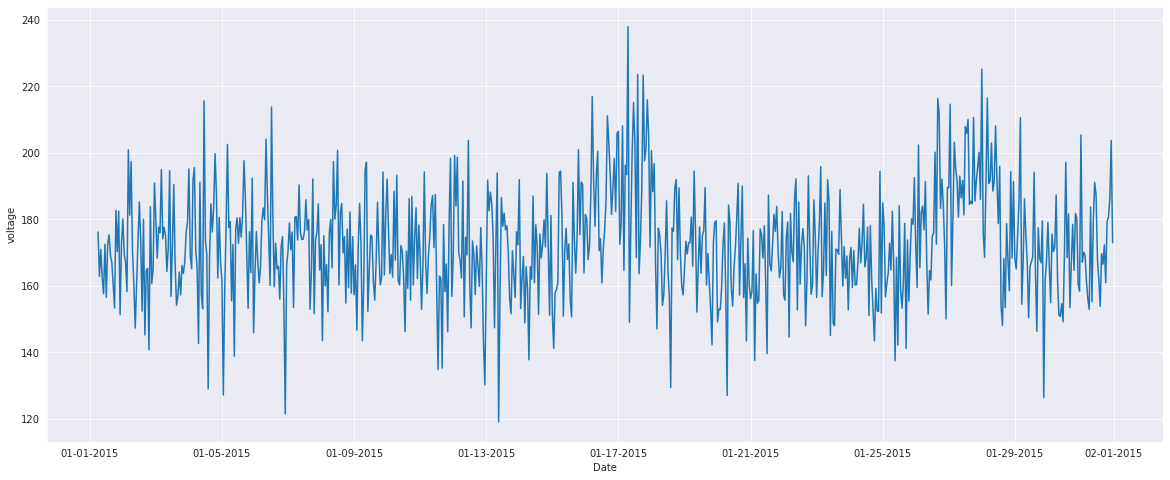

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                        ['datetime','volt']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y'
plt.xlabel('Date')

Text(0.5, 0, 'Date')

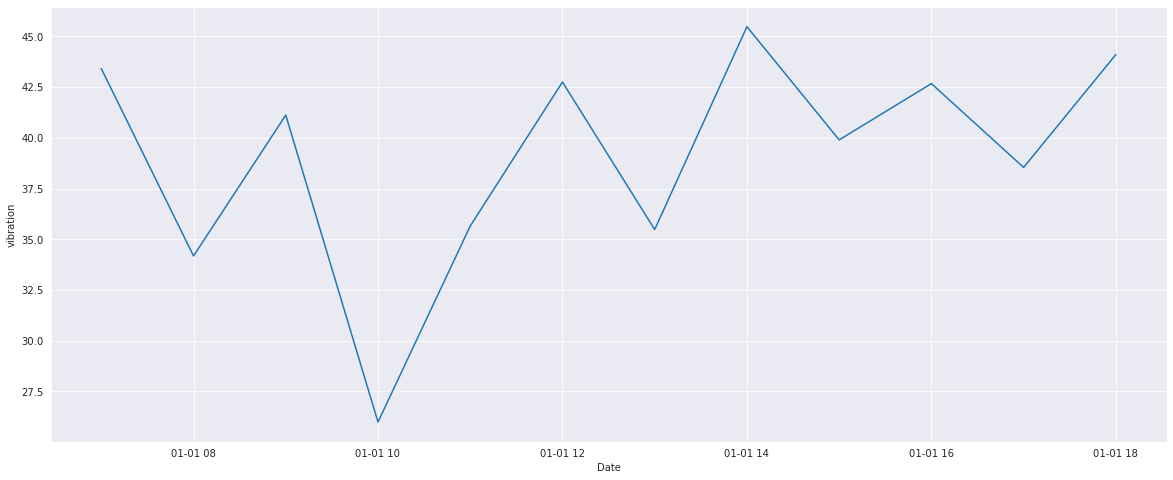

In [15]:
# vibration
plot_df_vib = telemetry.loc[(telemetry['machineID'] == 1) & 
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01 06:00:00')) & 
                        (telemetry['datetime'] <pd.to_datetime('2015-01-01 19:00:00')),
                        ['datetime','vibration']]
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
plt.plot(plot_df_vib['datetime'], plot_df_vib['vibration'])
plt.ylabel('vibration')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d-%Y %H:%M:%S'
plt.xlabel('Date')

In [17]:
plot_df_vib.head()

,datetime,vibration
1,2015-01-01 07:00:00,43.413973
2,2015-01-01 08:00:00,34.178847
3,2015-01-01 09:00:00,41.122144
4,2015-01-01 10:00:00,25.990511
5,2015-01-01 11:00:00,35.655017


#### **Errors**
The second major data source is the error logs. These are **non-breaking errors thrown while the machine is still operational and do not constitute as failures.** The **error date and times** are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [4]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()

Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

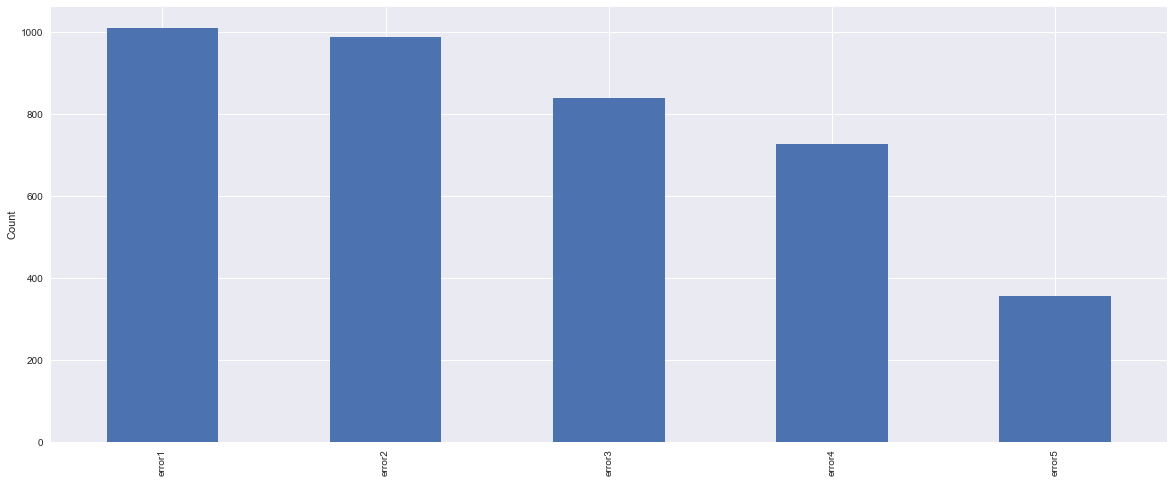

In [5]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 8))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')
errors['errorID'].value_counts()

#### **Maintenance**
These are the **scheduled and unscheduled** maintenance records which correspond to both **regular inspection of components as well as failures.** A **record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown.** The **records that are created due to breakdowns will be called failures** which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [6]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

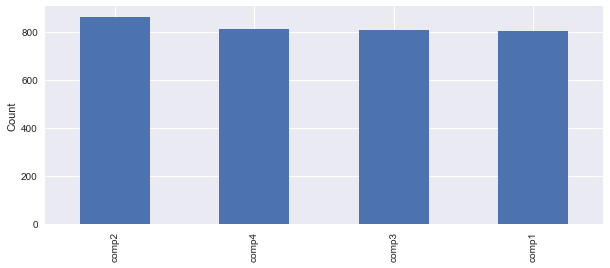

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')
maint['comp'].value_counts()

#### **Machines**
This data set includes some information about the machines: model type and age (years in service).

In [8]:
machines['model'] = machines['model'].astype('category')

print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


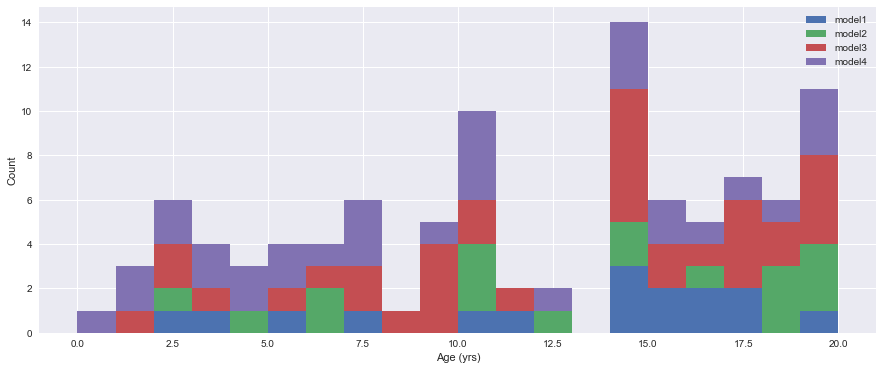

In [9]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

#### **Failures**
These are the records of component replacements **due to failures.** Each record has a **date and time, machine ID, and failed component type.**

In [10]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

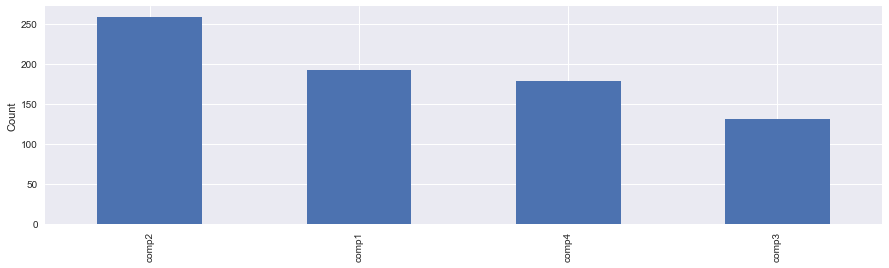

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')
failures['failure'].value_counts()

## Feature Engineering
The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry
Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [12]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [13]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='mean').unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right', how='std').unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  
C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).std()


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542



For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [14]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.rolling_mean(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col), window=24).resample('3H',
                                                                                closed='left',
                                                                                label='right',
                                                                                how='first').unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.rolling_std(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col), window=24).resample('3H',
                                                                                closed='left',
                                                                                label='right',
                                                                                how='first').unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()
  import sys
C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  # Remove the CWD from sys.path while we load stuff.
C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()
C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
12,1,2015-01-02 21:00:00,170.556674,452.267095,98.065860,40.033247
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [15]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.ix[:, 2:6],
                            telemetry_mean_24h.ix[:, 2:6],
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,170.775661,446.609874,100.857574,40.383881,14.919452,49.950788,10.046380,5.002089
std,28.798424,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,4.720237,18.070458,4.737293,2.058059,2.261097,7.684305,1.713206,0.799599
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.000000,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,168.072275,441.542561,98.669734,39.354077,13.359069,44.669022,8.924165,4.460675
50%,50.000000,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,170.212704,449.206885,100.099533,40.072618,14.854186,49.617459,9.921332,4.958793
75%,75.000000,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,172.462228,456.366349,101.613047,40.833112,16.395372,54.826993,10.980250,5.484430
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


In [16]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129


### Lag Features from Errors
Like telemetry data, errors come with timestamps. An important difference is that the **error IDs are categorical values** and **should not be averaged over time intervals like the telemetry measurements.** Instead, we count the number of errors of each type in a **lagging window. We begin by reformatting the error data** to have one entry per machine per time at which at least one error occurred:

In [17]:
errors

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
5,2015-01-25 15:00:00,1,error4
6,2015-01-27 04:00:00,1,error1
7,2015-03-03 22:00:00,1,error2
8,2015-03-05 06:00:00,1,error1
9,2015-03-20 18:00:00,1,error1


In [18]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [19]:
# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [20]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [21]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.rolling_sum(pd.pivot_table(error_count,
                                               index='datetime',
                                               columns='machineID',
                                               values=col), window=24).resample('3H',
                                                                             closed='left',
                                                                             label='right',
                                                                             how='first').unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).sum()
  import sys
C:\Program Files\Microsoft\ML Server\PYTHON_SERVER\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  # Remove the CWD from sys.path while we load stuff.


,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [22]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


### Days Since Last Replacement from Maintenance
A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [23]:
import numpy as np

# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [24]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


## Machine Features
The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [25]:
telemetry_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129
12,1,2015-01-02 21:00:00,163.278466,446.493166,104.387585,38.068116,21.580492,41.380958,20.725597,6.932127,170.556674,452.267095,98.065860,40.033247,14.187985,40.676672,11.942227,8.723238
13,1,2015-01-03 00:00:00,172.191198,434.214692,93.747282,39.716482,16.369836,14.636041,18.817326,3.426997,168.460525,451.031783,99.273286,38.903462,13.707794,40.509184,10.141026,8.634082
14,1,2015-01-03 03:00:00,175.210027,504.845430,108.512153,37.763933,5.991921,16.062702,6.382608,3.449468,169.772951,447.502464,99.005946,39.389725,11.818603,44.468516,9.444955,8.332673
15,1,2015-01-03 06:00:00,181.690108,472.783187,93.395164,38.621099,11.514450,47.880443,2.177029,7.670520,170.900562,453.864597,100.877342,38.696225,12.069391,46.669661,8.609526,8.089348
16,1,2015-01-03 09:00:00,172.382935,505.141261,98.524373,49.965572,7.065150,56.849540,5.230039,2.687565,169.533156,454.785072,100.050567,39.449734,12.755234,44.016114,9.893704,7.013132


In [26]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head())
final_feat.describe()

   machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

  ...   error2count  error3count  error4coun

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,...,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000
mean,50.380935,170.774427,446.609386,100.858340,40.383609,13.300173,44.453951,8.885780,4.440575,170.775661,...,0.027560,0.027058,0.022846,0.019955,0.009780,53.382610,51.256589,52.536687,53.679601,11.345226
std,28.798424,9.498824,33.119738,7.411701,3.475512,6.966389,23.214291,4.656364,2.319989,4.720237,...,0.166026,0.164401,0.151266,0.140998,0.098931,62.478424,59.156008,58.822946,59.658975,5.826345
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.447794,427.564793,96.239534,38.147458,8.028675,26.906319,5.369959,2.684556,168.072275,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000
50%,50.000000,170.432407,448.380260,100.235357,40.145874,12.495542,41.793798,8.345801,4.173704,170.212704,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.000000,176.610017,468.443933,104.406534,42.226898,17.688520,59.092354,11.789358,5.898512,172.462228,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,65.875000,67.125000,70.250000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


# Label Construction
When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "Â€Âœnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [31]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [35]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
21,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,1.0,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,comp4
22,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,0.0,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,comp4
23,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,0.0,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,comp4
24,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,comp4
1337,1,2015-06-18 09:00:00,169.324639,453.923471,101.313249,53.092274,28.155693,42.557599,7.688674,2.488851,...,0.0,0.0,1.0,89.125,29.125,14.125,134.125,model3,18,comp4
1338,1,2015-06-18 12:00:00,190.691297,441.577271,97.192512,44.025425,6.296827,47.271008,7.577957,4.648336,...,0.0,0.0,1.0,89.250,29.250,14.250,134.250,model3,18,comp4


# Modelling
After the feature engineering and labelling steps, either Azure Machine Learning Studio or this notebook can be used to create a predictive model. The recommend Azure Machine Learning Studio experiment can be found in the Cortana Intelligence Gallery: Predictive Maintenance Modelling Guide Experiment. Below, we describe the modelling process and provide an example Python model.

# Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model)

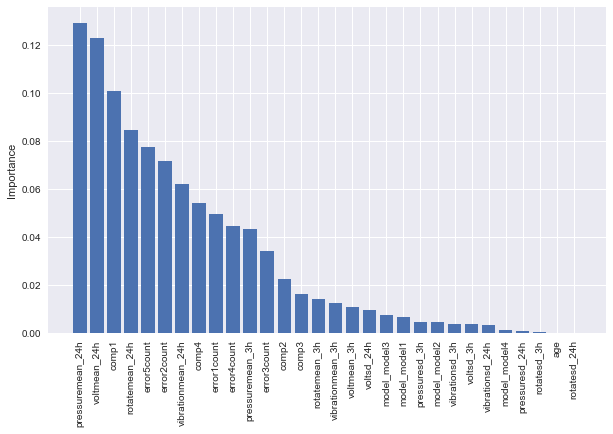

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

# Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

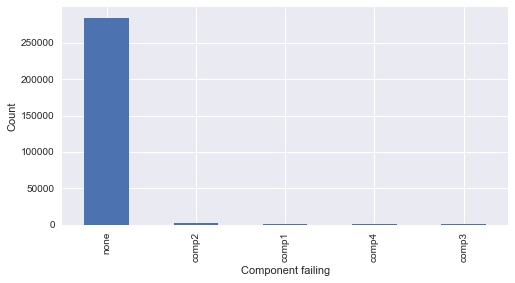

In [39]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of the metrics, please refer to the scikit-learn documentation and a companion blog post (with examples in R, not Python),

In [40]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [41]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[119594     21      0      4      3]
 [    18    515      3      5      1]
 [     0      0    860      0      1]
 [    13      0      2    372      1]
 [     2      2      6      0    497]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[95266    13     0     4     3]
 [   19   399     2     1     1]
 [    0     0   700     0     0]
 [   12     0     2   291     1]
 [    2     2     4     0   392]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[71724     7     0     4     3]
 [   17   300     1     1     1]
 [    0     1   547     0     0]
 [   11     0     0   212     1]
 [    2     1     3     0   274]]


,none,comp1,comp2,comp3,comp4
accuracy,0.999327,0.999327,0.999327,0.999327,0.999327
precision,0.999724,0.957249,0.987371,0.976378,0.988072
recall,0.999766,0.950185,0.998839,0.958763,0.980276
F1,0.999745,0.953704,0.993072,0.967490,0.984158
macro precision,0.981759,0.981759,0.981759,0.981759,0.981759
macro recall,0.977566,0.977566,0.977566,0.977566,0.977566
macro F1,0.979634,0.979634,0.979634,0.979634,0.979634
average accuracy,0.999731,0.999731,0.999731,0.999731,0.999731
micro-averaged precision/recall/F1,0.999327,0.999327,0.999327,0.999327,0.999327
majority class accuracy,0.981152,0.000000,0.000000,0.000000,0.000000
